## What to do?

Just run the cells that you need.
There's different sections for the different model architectures

In [37]:
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from time import time
from models import ResNet
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   


import training and validation data
not included in repo, set your own folder location

In [3]:
X_train = np.load('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

In [38]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'house', 'nine', 'four', 'happy', 'wow', 'five', 'zero', 'tree', 'six', 'one', 'three', 'eight', 'cat', 'two', 'seven', 'marvin', 'dog', 'sheila', 'bed', 'bird']


The training data is very unbalanced with a much larger 'unknown' class.
keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [5]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [6]:
class_weights

{0.0: 17.399810964083176,
 1.0: 17.490736342042755,
 2.0: 17.4080378250591,
 3.0: 17.574224343675418,
 4.0: 17.482431149097817,
 5.0: 17.441023211747986,
 6.0: 17.449289099526066,
 7.0: 17.52403617325083,
 8.0: 17.253045923149017,
 9.0: 17.432765151515152,
 10.0: 101.98891966759003,
 11.0: 1.0}

some constants we need for all models

In [7]:
input_size = X_train.shape[1:]
batch_size = 196

## First the ResNet
declare filters for each block of blocks and set output size.

In [8]:
filters_list = [8,16,32]
output_size = 12

#adjust these strings for organizeing the saved files
date = '1003'
arch = 'resnet8_16_32'

Build the model

In [18]:
sr = ResNet(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])

In [19]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [20]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

train the model
the history object stores training data for later access, like plotting training curves

In [21]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 5, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

Train on 58284 samples, validate on 6839 samples
Epoch 1/5
58284/58284 [==============================] - 34s 587us/step - loss: 9.2704 - acc: 0.3831 - val_loss: 7.5152 - val_acc: 0.1405
Epoch 2/5
58284/58284 [==============================] - 30s 521us/step - loss: 3.0444 - acc: 0.7537 - val_loss: 0.6088 - val_acc: 0.8027
Epoch 3/5
58284/58284 [==============================] - 31s 528us/step - loss: 2.0519 - acc: 0.8388 - val_loss: 0.4001 - val_acc: 0.8893
Epoch 4/5
58284/58284 [==============================] - 31s 528us/step - loss: 1.6024 - acc: 0.8799 - val_loss: 3.2375 - val_acc: 0.4138
Epoch 5/5
58284/58284 [==============================] - 31s 534us/step - loss: 1.3478 - acc: 0.8977 - val_loss: 2.7000 - val_acc: 0.4758


In [22]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


plot the training graphs, and save them

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


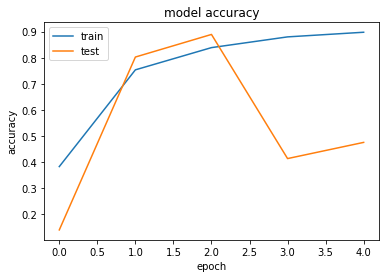

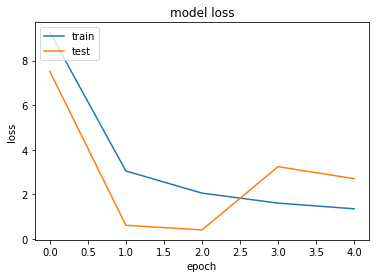

In [23]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

predict the validation classification and score

In [25]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

6839/6839 [==============================] - 2s 221us/step


In [32]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

             precision    recall  f1-score   support

        yes      0.420     0.939     0.581       261
         no      0.696     0.933     0.797       270
         up      0.927     0.442     0.599       260
       down      0.210     0.966     0.345       264
       left      0.265     0.980     0.418       247
      right      0.213     0.977     0.349       256
         on      0.914     0.743     0.820       257
        off      0.544     0.980     0.700       256
       stop      0.757     0.911     0.827       246
         go      0.462     0.862     0.601       260
    silence      0.759     1.000     0.863        41
    unknown      1.000     0.228     0.372      4221

avg / total      0.826     0.476     0.462      6839



In [34]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[245   1   0   2  10   0   0   0   0   2   1   0]
 [  0 252   0   1   5   1   0   0   0  11   0   0]
 [  0   0 115   4  43   4   0  88   2   4   0   0]
 [  0   5   0 255   1   0   0   0   1   2   0   0]
 [  0   1   0   1 242   3   0   0   0   0   0   0]
 [  1   0   0   0   3 250   0   1   0   1   0   0]
 [  0   0   0  18   2  21 191  23   0   1   1   0]
 [  0   0   0   0   2   0   1 251   0   2   0   0]
 [  1   0   0   8   5   1   0   5 224   1   1   0]
 [  0   9   1  14   7   1   0   2   0 224   2   0]
 [  0   0   0   0   0   0   0   0   0   0  41   0]
 [336  94   8 911 592 894  17  91  69 237   8 964]]


## Now the CTC model

In [ ]:
# dummy loss
def ctc(y_true, y_pred):
    return y_pred